In [1]:
import pandas as pd
import numpy as  np

import os
os.listdir('../input')

['sample_submission.csv',
 'test.csv',
 'test2.csv',
 'test_original.csv',
 'test_sqft.csv',
 'train.csv',
 'train2.csv',
 'train_original.csv',
 'train_sqft.csv']

In [2]:
train = pd.read_csv('../input/train2.csv')
test = pd.read_csv('../input/test2.csv')

In [4]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# Kmeans train-test separate

In [10]:
position = train[['long','lat']]

mms = MinMaxScaler()
position_transformed = mms.fit_transform(position)

In [15]:
import matplotlib.pyplot as plt

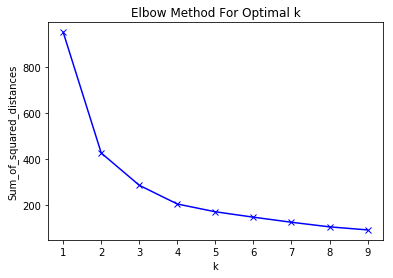

In [16]:
SSD = []

for k in range(1,10):
    km = KMeans(n_clusters = k)
    km = km.fit(position_transformed)
    SSD.append(km.inertia_)
    
plt.plot(range(1,10), SSD, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [18]:
k=3
km = KMeans(n_clusters = k, algorithm = 'auto')
km.fit(position_transformed)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [23]:
train['position'] = km.predict(position_transformed)

In [24]:
position = test[['long','lat']]

mms = MinMaxScaler()
position_transformed = mms.fit_transform(position)

In [25]:
k=3
km = KMeans(n_clusters = k, algorithm = 'auto')
km.fit(position_transformed)
test['position'] = km.predict(position_transformed)

## xgboost

In [29]:
import xgboost as xgb

In [31]:
x_train = train.drop(['id', 'price','date'], axis = 1)
y_train = train['price']
x_test = test.drop(['id','date'], axis = 1)

In [32]:
xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

print('Transform DMatrix...')
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)

print('Start Cross Validation...')

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=5000, early_stopping_rounds=20,verbose_eval=50, show_stdv=False)


Transform DMatrix...
Start Cross Validation...


C:\Users\wjssm\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\wjssm\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-rmse:650014	test-rmse:650101
[50]	train-rmse:416368	test-rmse:420421
[100]	train-rmse:276690	test-rmse:286702
[150]	train-rmse:194584	test-rmse:211197
[200]	train-rmse:147502	test-rmse:171314
[250]	train-rmse:120835	test-rmse:151186
[300]	train-rmse:105719	test-rmse:141109
[350]	train-rmse:97097	test-rmse:135700
[400]	train-rmse:91806.4	test-rmse:132749
[450]	train-rmse:88028.8	test-rmse:130776
[500]	train-rmse:85193.5	test-rmse:129480
[550]	train-rmse:82888.2	test-rmse:128423
[600]	train-rmse:80950.9	test-rmse:127624
[650]	train-rmse:79245	test-rmse:126999
[700]	train-rmse:77706.1	test-rmse:126573
[750]	train-rmse:76114.2	test-rmse:126031
[800]	train-rmse:74532.3	test-rmse:125524
[850]	train-rmse:73055.1	test-rmse:125113
[900]	train-rmse:71689.7	test-rmse:124780
[950]	train-rmse:70272.7	test-rmse:124413
[1000]	train-rmse:69011.2	test-rmse:124148
[1050]	train-rmse:67726.6	test-rmse:123865
[1100]	train-rmse:66549	test-rmse:123592
[1150]	train-rmse:65472.5	test-rmse:123395
[120

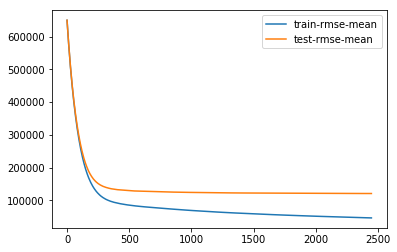

In [33]:
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

In [34]:
print('best num_boost_rounds = ', len(cv_output))
rounds = len(cv_output)
rounds

best num_boost_rounds =  2448


2448

In [35]:
model = xgb.train(xgb_params, dtrain, num_boost_round = rounds)
preds = model.predict(dtest)
sub = pd.DataFrame({'id':test.id, 'price' : preds} )

In [36]:
#sub.to_csv('../sub/sub_xgb_train_knn_190325.csv', index=False) - 110105.41487